<a href="https://colab.research.google.com/github/srush/Triton-Puzzles/blob/main/Triton-Puzzles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Triton Puzzles

Programming for accelerators such as GPUs is critical for modern AI systems.
This often means programming directly in proprietary low-level languages such as CUDA. [Triton](https://github.com/openai/triton/) is an alternative open-source language that allows you to code at a higher-level and compile to accelerators like GPU.

Coding for Triton is very similar to Numpy and PyTorch in both syntax and semantics. However, as a lower-level language there are a lot of details that you need to keep track of. In particular, one area that learners have trouble with is memory loading and storage which is critical for speed on low-level devices.

This set is puzzles is meant to teach you how to use Triton from first principles in an interactive fashion. You will start with trivial examples and build your way up to real algorithms like Flash Attention and Quantized neural networks. These puzzles **do not** need to run on GPU since they use a Triton interpreter.




In [ ]:
import torch
import triton
from torch import Tensor
import triton.language as tl
from jaxtyping import Float32, Int32

In [ ]:
import triton_viz
import inspect
from triton_viz.interpreter import record_builder

def test(puzzle, puzzle_spec, nelem={}, B={"B0": 32}, viz=True):
    B = dict(B)
    if "N1" in nelem and "B1" not in B:
        B["B1"] = 32
    if "N2" in nelem and "B2" not in B:
        B["B2"] = 32

    triton_viz.interpreter.record_builder.reset()
    torch.manual_seed(0)
    signature = inspect.signature(puzzle_spec)
    args = {}
    for n, p in signature.parameters.items():
        print(p)
        args[n + "_ptr"] = ([d.size for d in p.annotation.dims], p)
    args["z_ptr"] = ([d.size for d in signature.return_annotation.dims], None)

    tt_args = []
    for k, (v, t) in args.items():
        tt_args.append(torch.rand(*v) - 0.5)
        if t is not None and t.annotation.dtypes[0] == "int32":
            tt_args[-1] = torch.randint(-100000, 100000, v)
    grid = lambda meta: (triton.cdiv(nelem["N0"], meta["B0"]),
                         triton.cdiv(nelem.get("N1", 1), meta.get("B1", 1)),
                         triton.cdiv(nelem.get("N2", 1), meta.get("B2", 1)))

    #for k, v in args.items():
    #    print(k, v)
    triton_viz.trace(puzzle)[grid](*tt_args, **B, **nelem)
    z = tt_args[-1]
    tt_args = tt_args[:-1]
    z_ = puzzle_spec(*tt_args)
    match = torch.allclose(z, z_, rtol=1e-3, atol=1e-3)
    print("Results match:",  match)
    failures = False
    if viz:
        failures = triton_viz.launch()
    if not match or failures:
        print("Invalid Access:", failures)
        print("Yours:", z)
        print("Spec:", z_)
        print(torch.isclose(z, z_))
        return
    # PUPPIES!
    from IPython.display import HTML
    import random
    print("Correct!")
    pups = [
    "2m78jPG",
    "pn1e9TO",
    "MQCIwzT",
    "udLK6FS",
    "ZNem5o3",
    "DS2IZ6K",
    "aydRUz8",
    "MVUdQYK",
    "kLvno0p",
    "wScLiVz",
    "Z0TII8i",
    "F1SChho",
    "9hRi2jN",
    "lvzRF3W",
    "fqHxOGI",
    "1xeUYme",
    "6tVqKyM",
    "CCxZ6Wr",
    "lMW0OPQ",
    "wHVpHVG",
    "Wj2PGRl",
    "HlaTE8H",
    "k5jALH0",
    "3V37Hqr",
    "Eq2uMTA",
    "Vy9JShx",
    "g9I2ZmK",
    "Nu4RH7f",
    "sWp0Dqd",
    "bRKfspn",
    "qawCMl5",
    "2F6j2B4",
    "fiJxCVA",
    "pCAIlxD",
    "zJx2skh",
    "2Gdl1u7",
    "aJJAY4c",
    "ros6RLC",
    "DKLBJh7",
    "eyxH0Wc",
    "rJEkEw4"]
    return HTML("""
    <video alt="test" controls autoplay=1>
        <source src="https://openpuppies.com/mp4/%s.mp4"  type="video/mp4">
    </video>
    """%(random.sample(pups, 1)[0]))

## Introduction

To begin with, we will only use `tl.load` and `tl.store` in order to build simple programs.

Here's an example of load. It takes an `arange` over the memory. By default the indexing of torch tensors with column, rows, depths or right-to-left. It also takes in a mask as the second argument. Mask is critically important because all shapes in Triton need to be powers of two.

In [ ]:
@triton.jit
def demo(x_ptr):
    range = tl.arange(0, 8)
    # print works in the interpreter
    print(range)
    x = tl.load(x_ptr + range, range < 5, 0)
    print(x)

triton_viz.trace(demo)[(1, 1, 1)](torch.ones(4, 3))
triton_viz.launch()

You can also use this trick to read in a 2d array.

In [ ]:
@triton.jit
def demo(x_ptr):
    i_range = tl.arange(0, 8)[:, None]
    j_range = tl.arange(0, 4)[None, :]
    range = i_range * 4 + j_range
    # print works in the interpreter
    print(range)
    x = tl.load(x_ptr + range, (i_range < 4) & (j_range < 3), 0)
    print(x)

triton_viz.trace(demo)[(1, 1, 1)](torch.ones(4, 4))
triton_viz.launch()

The `tl.store` function is quite similar. It allows you to write to a tensor.

In [ ]:
@triton.jit
def demo(z_ptr):
    range = tl.arange(0, 8)
    z = tl.store(z_ptr + range, 10, range < 5)

z = torch.ones(4, 3)
triton_viz.trace(demo)[(1, 1, 1)](z)
print(z)
triton_viz.launch()

You can only load in relatively small `blocks` at a time in Triton. to work with larger tensors you need to use a program id axis to run multiple blocks in parallel. Here is an example with one program axis with 3 blocks. You can use the visualizer to scroll over it.

In [ ]:
@triton.jit
def demo(x_ptr):
    pid = tl.program_id(0)
    range = tl.arange(0, 8) + pid * 8
    x = tl.load(x_ptr + range, range < 20)
    print("Print for each", pid, x)

x = torch.ones(2, 4, 4)
triton_viz.trace(demo)[(3, 1, 1)](x)
triton_viz.launch()

See the [Triton Docs](https://triton-lang.org/main/index.html) for further information.

## Puzzle 1: Constant Add

Add a constant to a vector. Uses one program id axis. Block size `B0` is always the same as vector `x` with length `N0`.


$$z_i = 10 + x_i \text{ for } i = 1\ldots N_0$$


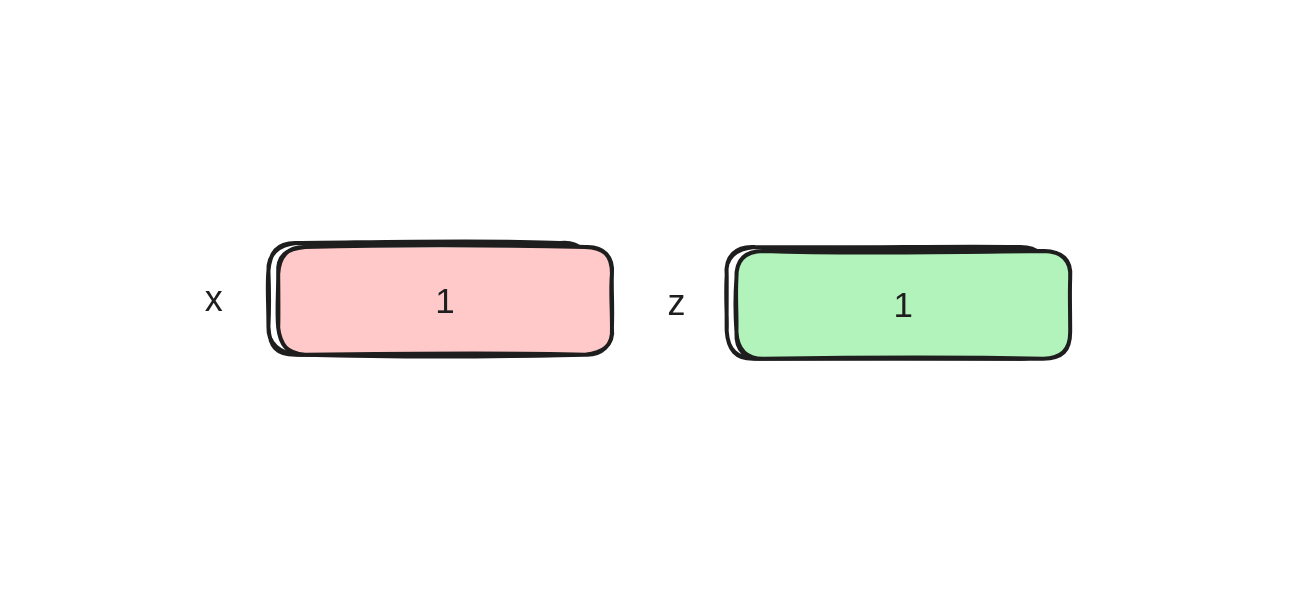

In [ ]:
def add_spec(x: Float32[Tensor, "32"]) -> Float32[Tensor, "32"]:
    "This is the spec that you should implement. Uses typing to define sizes."
    return x + 10.

@triton.jit
def add_kernel(x_ptr, z_ptr, N0, B0: tl.constexpr):
    range = tl.arange(0, B0)
    x = tl.load(x_ptr + range)
    
    # store results directly
    tl.store(z_ptr + range, x + 10, range < N0)
    
test(add_kernel, add_spec, nelem={"N0": 32}, viz=True)

## Puzzle 2: Constant Add Block

Add a constant to a vector. Uses one program block axis (no `for` loops yet). Block size `B0` is now smaller than the shape vector `x` which is `N0`.


$$z_i = 10 + x_i \text{ for } i = 1\ldots N_0$$



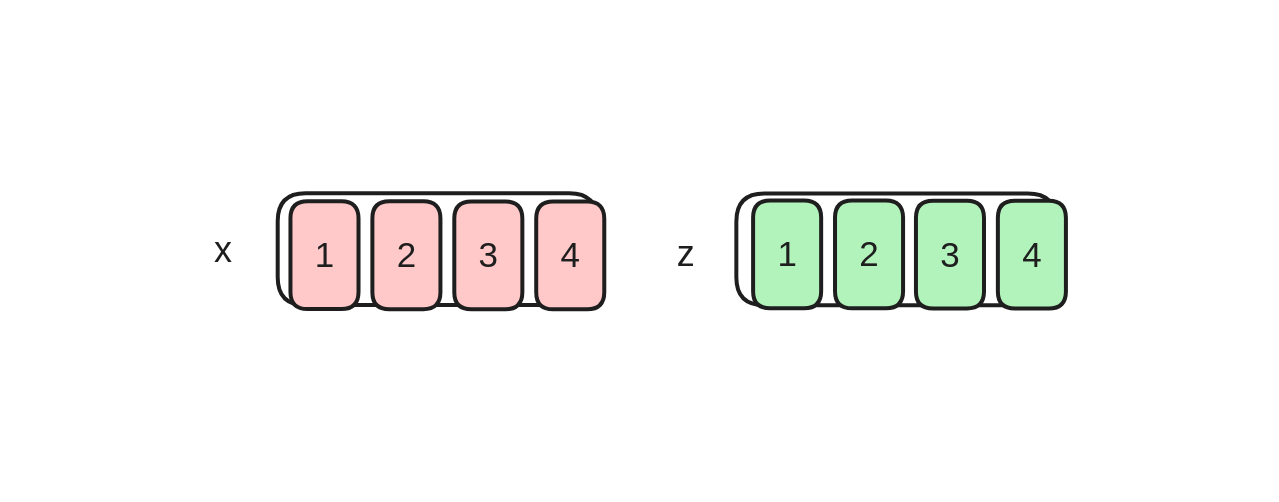

In [ ]:
def add2_spec(x: Float32[Tensor, "200"]) -> Float32[Tensor, "200"]:
    return x + 10.

@triton.jit
def add_mask2_kernel(x_ptr, z_ptr, N0, B0: tl.constexpr):
    # load according to pid
    pid = tl.program_id(0)
    range = tl.arange(0, B0) + pid * B0
    x = tl.load(x_ptr + range)

    # store at correct position
    tl.store(z_ptr + range, x + 10, range < N0) 

test(add_mask2_kernel, add2_spec, nelem={"N0": 200})

## Puzzle 3: Outer Vector Add

Add two vectors.

Uses one program block axis. Block size `B0` is always the same as vector `x` length `N0`.
Block size `B1` is always the same as vector `y` length `N1`.


$$z_{j, i} = x_i + y_j\text{ for } i = 1\ldots B_0,\ j = 1\ldots B_1$$


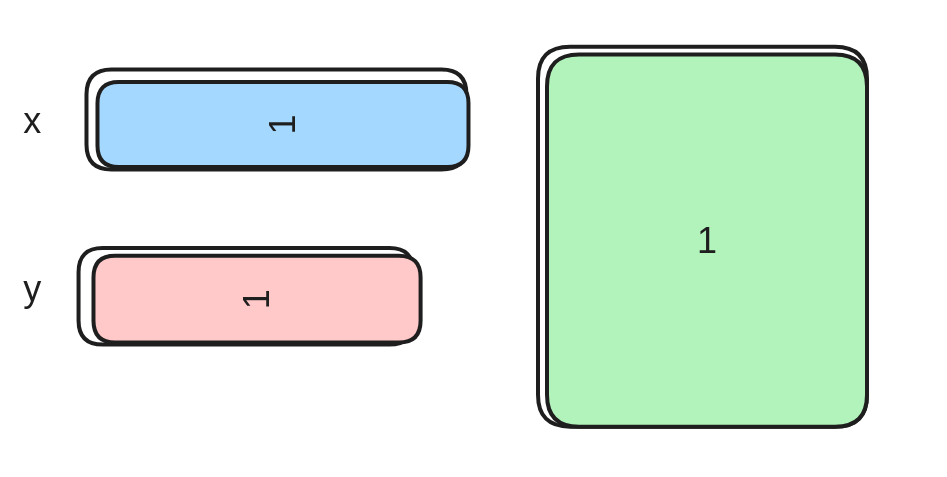

In [ ]:
def add_vec_spec(x: Float32[Tensor, "32"], y: Float32[Tensor, "32"]) -> Float32[Tensor, "32 32"]:
    return x[None, :] + y[:, None]

@triton.jit
def add_vec_kernel(x_ptr, y_ptr, z_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
    range_x = tl.arange(0, B0)
    range_y = tl.arange(0, B1)
    
    x = tl.load(x_ptr + range_x, range_x < N0)
    y = tl.load(y_ptr + range_y, range_y < N1)
    
    # x[None, :]
    x = tl.broadcast_to(tl.expand_dims(x, axis=0), (B1, B0))
    # y[:, None]
    y = tl.broadcast_to(tl.expand_dims(y, axis=1), (B1, B0))
    # (x + y).flatten() 
    xy = tl.ravel(x + y)

    # store results in flattened layout
    z_range = tl.arange(0, B0 * B1)
    z = tl.load(z_ptr + z_range)
    tl.store(z_ptr + z_range, xy)
    
    # change layout back to 2D
    z = tl.reshape(z, (B1, B0))

test(add_vec_kernel, add_vec_spec, nelem={"N0": 32, "N1": 32})

## Puzzle 4: Outer Vector Add Block

Add a row vector to a column vector.

Uses two program block axes. Block size `B0` is always less than the vector `x` length `N0`.
Block size `B1` is always less than vector `y` length `N1`.

$$z_{j, i} = x_i + y_j\text{ for } i = 1\ldots N_0,\ j = 1\ldots N_1$$


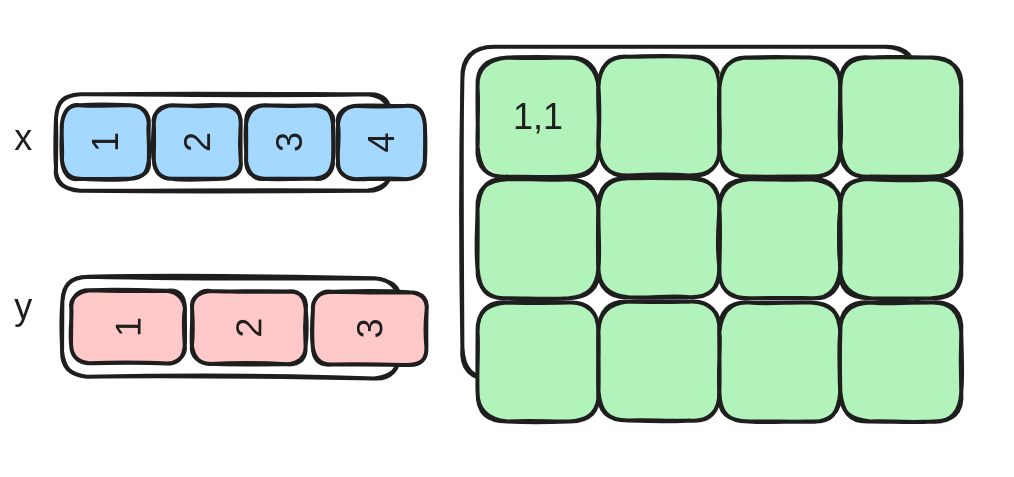

In [ ]:
def add_vec_block_spec(x: Float32[Tensor, "100"], y: Float32[Tensor, "90"]) -> Float32[Tensor, "90 100"]:
    return x[None, :] + y[:, None]

@triton.jit
def add_vec_block_kernel(x_ptr, y_ptr, z_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
    # TODO: here
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)
    return

test(add_vec_block_kernel, add_vec_block_spec, nelem={"N0": 100, "N1": 90})

## Puzzle 5: Fused Outer Multiplication

Multiply a row vector to a column vector and take a relu.

Uses two program block axes. Block size `B0` is always less than the vector `x` length `N0`.
Block size `B1` is always less than vector `y` length `N1`.

$$z_{j, i} = \text{relu}(x_i \times y_j)\text{ for } i = 1\ldots N_0,\ j = 1\ldots N_1$$



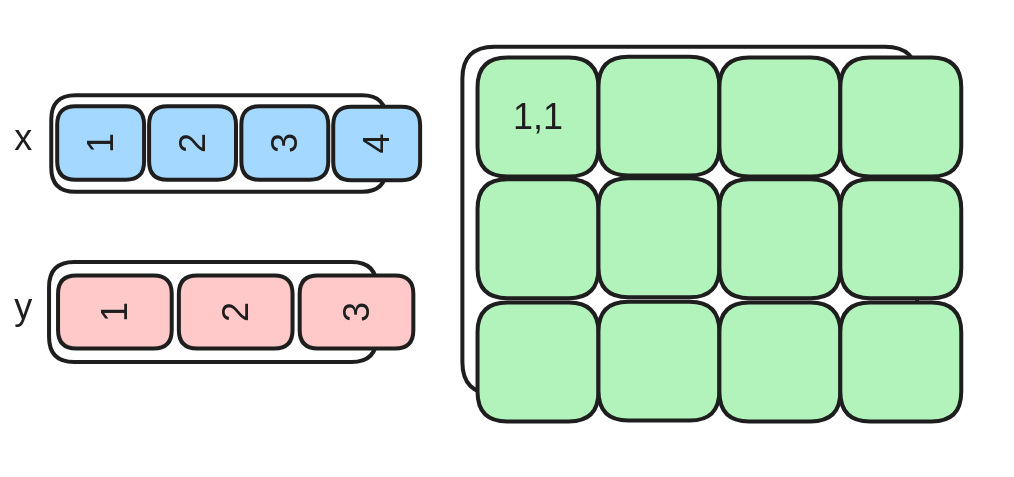

In [ ]:
def mul_relu_block_spec(x: Float32[Tensor, "100"], y: Float32[Tensor, "90"]) -> Float32[Tensor, "90 100"]:
    return torch.relu(x[None, :] * y[:, None])

@triton.jit
def mul_relu_block_kernel(x_ptr, y_ptr, z_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)
    return

test(mul_relu_block_kernel, mul_relu_block_spec, nelem={"N0": 100, "N1": 90})

## Puzzle 6: Fused Outer Multiplication - Backwards


Backwards of a function that multiplies a matrix with a row vector and take a relu.

Uses two program blocks. Block size `B0` is always less than the vector `x` length `N0`.
Block size `B1` is always less than vector `y` length `N1`. Chain rule backward `dz`
is of shape `N1` by `N0`

$$f(x, y) = \text{relu}(x_i \times y_j)\text{ for } i = 1\ldots N_0,\ j = 1\ldots N_1$$

$$dx_{i, j} = f_x'(x, y)_{i, j} \times dz_{i,j}$$

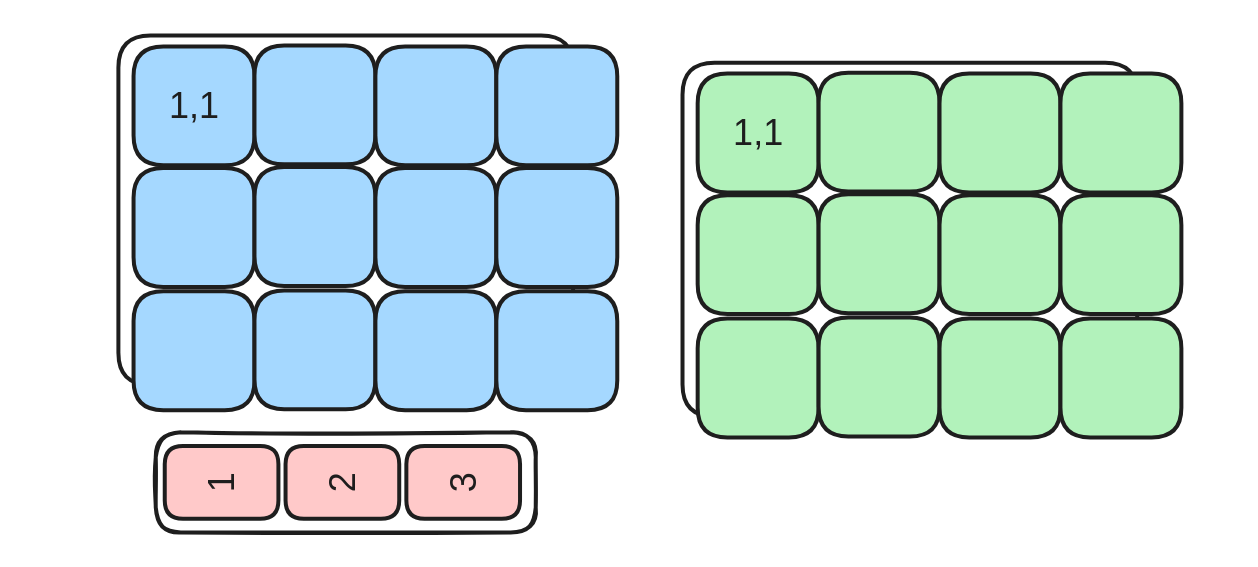

In [ ]:
def mul_relu_block_back_spec(x: Float32[Tensor, "90 100"], y: Float32[Tensor, "90"],
                             dz: Float32[Tensor, "90 100"]) -> Float32[Tensor, "90 100"]:
    x = x.clone()
    y = y.clone()
    x = x.requires_grad_(True)
    y = y.requires_grad_(True)
    z = torch.relu(x * y[:, None])
    z.backward(dz)
    dx = x.grad
    return dx

@triton.jit
def mul_relu_block_back_kernel(x_ptr, y_ptr, dz_ptr, dx_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)
    return

test(mul_relu_block_back_kernel, mul_relu_block_back_spec, nelem={"N0": 100, "N1": 90})


## Puzzle 7: Long Sum

Sum of a batch of numbers.

Uses one program blocks. Block size `B0` represents a range of batches of  `x` of length `N0`.
Each element is of length `T`. Process it `B1 < T` elements at a time.  

$$z_{i} = \sum^{T}_j x_{i,j} =  \text{ for } i = 1\ldots N_0$$

Hint: You will need a for loop for this problem. These work and look the same as in Python.

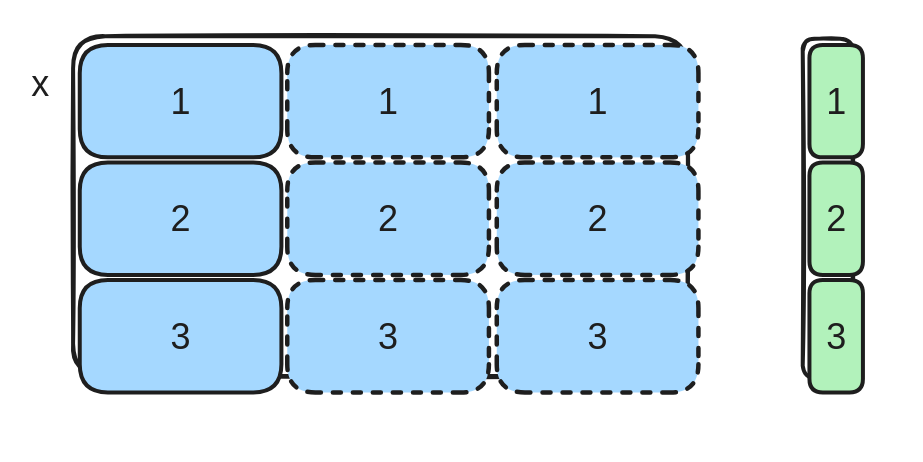

In [ ]:
def sum_spec(x: Float32[Tensor, "4 200"]) -> Float32[Tensor, "4"]:
    return x.sum(1)

@triton.jit
def sum_kernel(x_ptr, z_ptr, N0, N1, T, B0: tl.constexpr, B1: tl.constexpr):
    return

test(sum_kernel, sum_spec, B={"B0": 1, "B1": 32}, nelem={"N0": 4, "N1": 32, "T": 200})


## Puzzle 8: Long Softmax


Softmax of a batch of logits.

Uses one program block axis. Block size `B0` represents the batch of `x` of length `N0`.
Block logit length `T`.   Process it `B1 < T` elements at a time.  

$$z_{i, j} = \text{softmax}(x_{i,1} \ldots x_{i, T}) \text{ for } i = 1\ldots N_0$$

Note softmax needs to be computed in numerically stable form as in Python. In addition in Triton they recommend not using `exp` but instead using `exp2`. You need the identity

$$\exp(x) = 2^{\log_2(e) x}$$

Advanced: there one way to do this with 3 loops. You can also do it with 2 loops if you are clever. Hint: you will find this identity useful:

$$\exp(x_i - m) =  \exp(x_i - m/2 - m/2) = \exp(x_i - m/ 2) /  \exp(m/2) $$

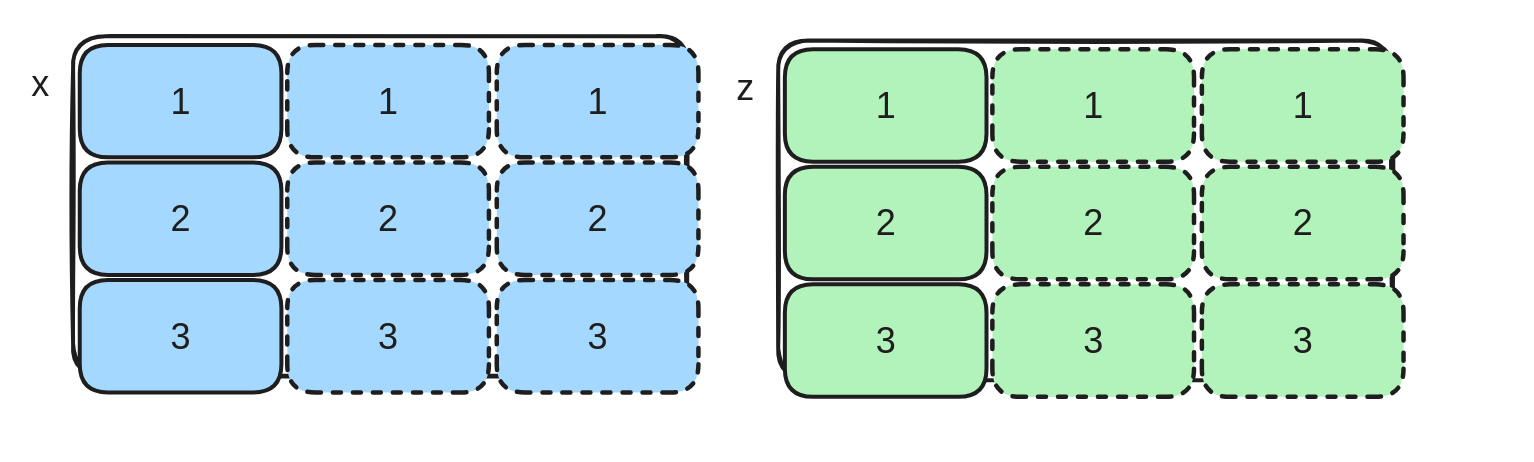

In [ ]:
def softmax_spec(x: Float32[Tensor, "4 200"]) -> Float32[Tensor, "4 200"]:
    x_max = x.max(1, keepdim=True)[0]
    x = x - x_max
    x_exp = x.exp()
    return x_exp / x_exp.sum(1, keepdim=True)

@triton.jit
def softmax_kernel(x_ptr, z_ptr, N0, N1, T, B0: tl.constexpr, B1: tl.constexpr):
    pid_0 = tl.program_id(0)
    log2_e = 1.44269504
    return

test(softmax_kernel, softmax_spec, B={"B0": 1, "B1":32},
     nelem={"N0": 4, "N1": 32, "T": 200})


## Puzzle 9: Simple FlashAttention

A scalar version of FlashAttention.

Uses zero programs. Block size `B0` represents `k` of length `N0`.
Block size `B0` represents `q` of length `N0`. Block size `B0` represents `v` of length `N0`.
Sequence length is `T`. Process it `B1 < T` elements at a time.  

$$z_{i} = \sum_{j} \text{softmax}(q_1 k_1, \ldots, q_T k_T)_j v_{j} \text{ for } i = 1\ldots N_0$$

This can be done in 1 loop using a similar trick from the last puzzle.

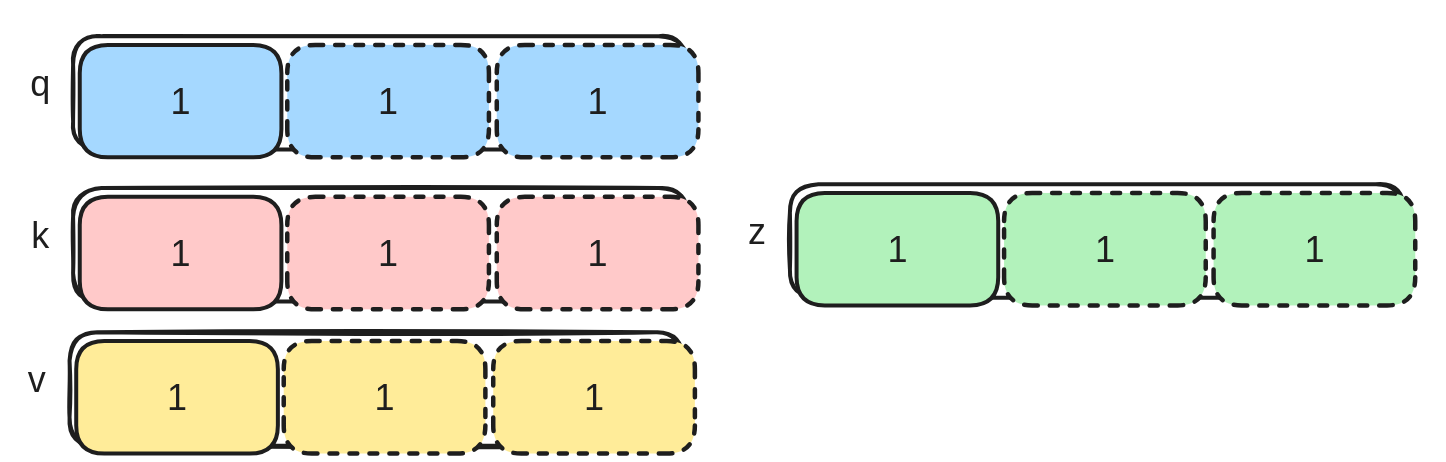

In [ ]:
def flashatt_spec(q: Float32[Tensor, "200"], k: Float32[Tensor, "200"], v: Float32[Tensor, "200"]) -> Float32[Tensor, "200"]:
    x = q[:, None] * k[None, :]
    x_max = x.max(1, keepdim=True)[0]
    x = x - x_max
    x_exp = x.exp()
    soft =  x_exp  / x_exp.sum(1, keepdim=True)
    return (v[None, :] * soft).sum(1)

@triton.jit
def flashatt_kernel(q_ptr, k_ptr, v_ptr, z_ptr, N0, T, B0: tl.constexpr):
    return

test(flashatt_kernel, flashatt_spec, B={"B0":200},
     nelem={"N0": 200, "T": 200})

## Puzzle 10: Two Dimensional Convolution

A batched 2D convolution.

Uses one program id axis. Block size `B0` represent the batches to process out of `N0`.
Image `x` is size is `H` by `W` with only 1 channel, and kernel `k` is size `KH` by `KW`.

$$z_{i, j, k} = \sum_{oj, ok} k_{oj,ok} \times x_{i,j + oj, k + ok} \text{ for } i = 1\ldots N_0$$



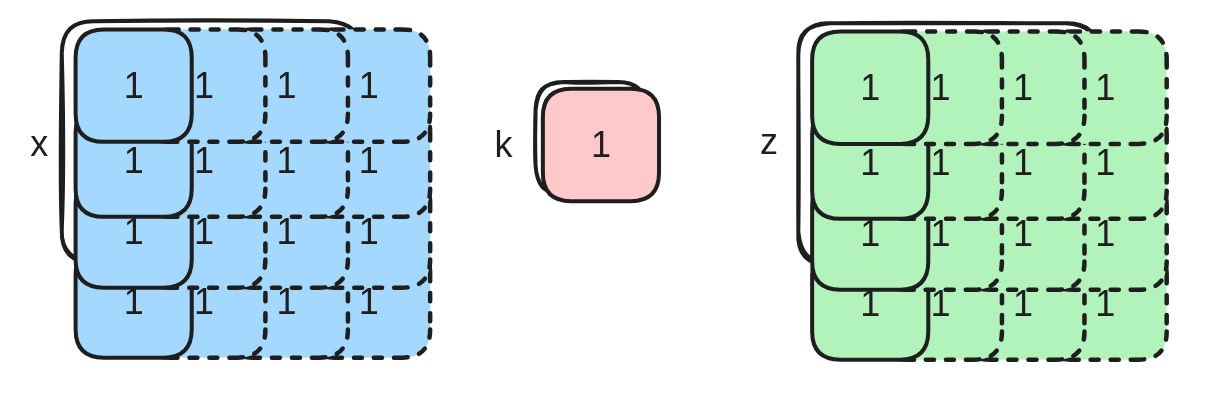

In [ ]:
def conv2d_spec(x: Float32[Tensor, "4 8 8"], k: Float32[Tensor, "4 4"]) -> Float32[Tensor, "4 8 8"]:
    z = torch.zeros(4, 8, 8)
    x = torch.nn.functional.pad(x, (0, 4, 0, 4, 0, 0), value=0.0)
    print(x.shape, k.shape)
    for i in range(8):
        for j in range(8):
            z[:, i, j] = (k[None, :, :] * x[:, i: i+4, j: j + 4]).sum(1).sum(1)
    return z


@triton.jit
def conv2d_kernel(x_ptr, k_ptr, z_ptr, N0, H, W, KH: tl.constexpr, KW: tl.constexpr, B0: tl.constexpr):
    pid_0 = tl.program_id(0)
    return

test(conv2d_kernel, conv2d_spec, B={"B0": 1}, nelem={"N0": 4, "H": 8, "W": 8, "KH": 4, "KW": 4})

## Puzzle 11: Matrix Multiplication

A blocked matrix multiplication.

Uses three program id axes. Block size `B2` represent the batches to process out of `N2`.
Block size `B0` represent the rows of `x` to process out of `N0`. Block size `B1` represent the cols of `y` to process out of `N1`. The middle shape is `MID`.

$$z_{i, j, k} = \sum_{l} x_{i,j, l} \times y_{i, l, k} \text{ for } i = 1\ldots N_2, j = 1\ldots N_0, k = 1\ldots N_1$$

You are allowed to use `tl.dot` which computes a smaller mat mul.

Hint: the main trick is that you can split a matmul into smaller parts.

$$z_{i, j, k} = \sum_{l=1}^{L/2} x_{i,j, l} \times y_{i, l, k} +  \sum_{l=L/2}^{L} x_{i,j, l} \times y_{i, l, k} $$


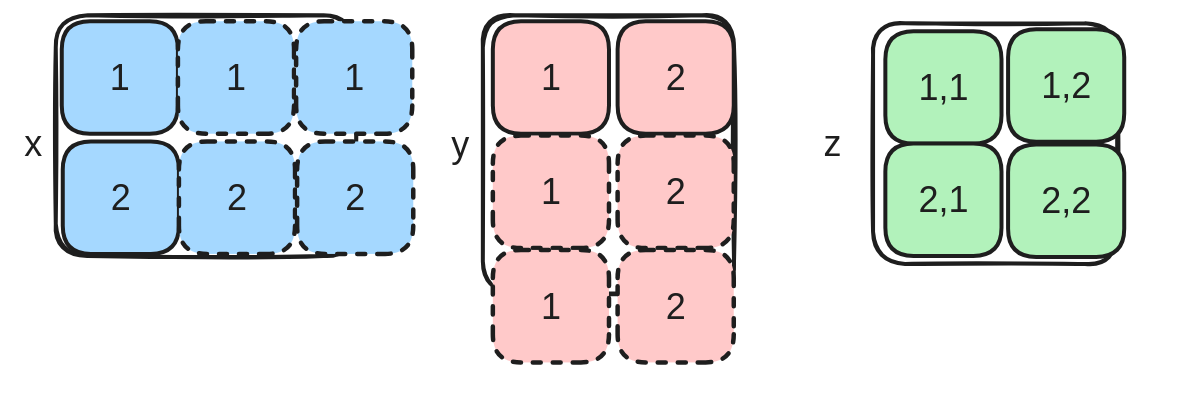

In [ ]:
def dot_spec(x: Float32[Tensor, "4 32 32"], y: Float32[Tensor, "4 32 32"]) -> Float32[Tensor, "4 32 32"]:
    return x @ y

@triton.jit
def dot_kernel(x_ptr, y_ptr, z_ptr, N0, N1, N2, MID, B0: tl.constexpr, B1: tl.constexpr, B2: tl.constexpr, B_MID: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)
    pid_2 = tl.program_id(2)

test(dot_kernel, dot_spec, B={"B0": 16, "B1": 16, "B2": 1, "B_MID": 16}, nelem={"N0": 32, "N1": 32, "N2": 4, "MID": 32})


## Puzzle 12: Quantized Matrix Mult

When doing matrix multiplication with quantized neural networks a common strategy is to store the weight matrix in lower precision, with a shift and scale term.

For this problem our `weight` will be stored in 4 bits. We can store `FPINT` of these in a 32 bit integer. In addition for every `group` weights in order we will store 1 `scale` float value and 1 `shift` 4 bit value. We store these for the column of weight. The `activation`s are stored separately in standard floats.

Mathematically it looks like.

$$z_{j, k} = \sum_{l} sc_{j, \frac{l}{g}} (w_{j, l} - sh_{j, \frac{l}{g}}) \times y_{l, k} \text{ for } i = 1\ldots N_2, j = 1\ldots N_0, k = 1\ldots N_1$$

However, it is a bit more complex since we need to also extract the 4-bit values into floats to begin.




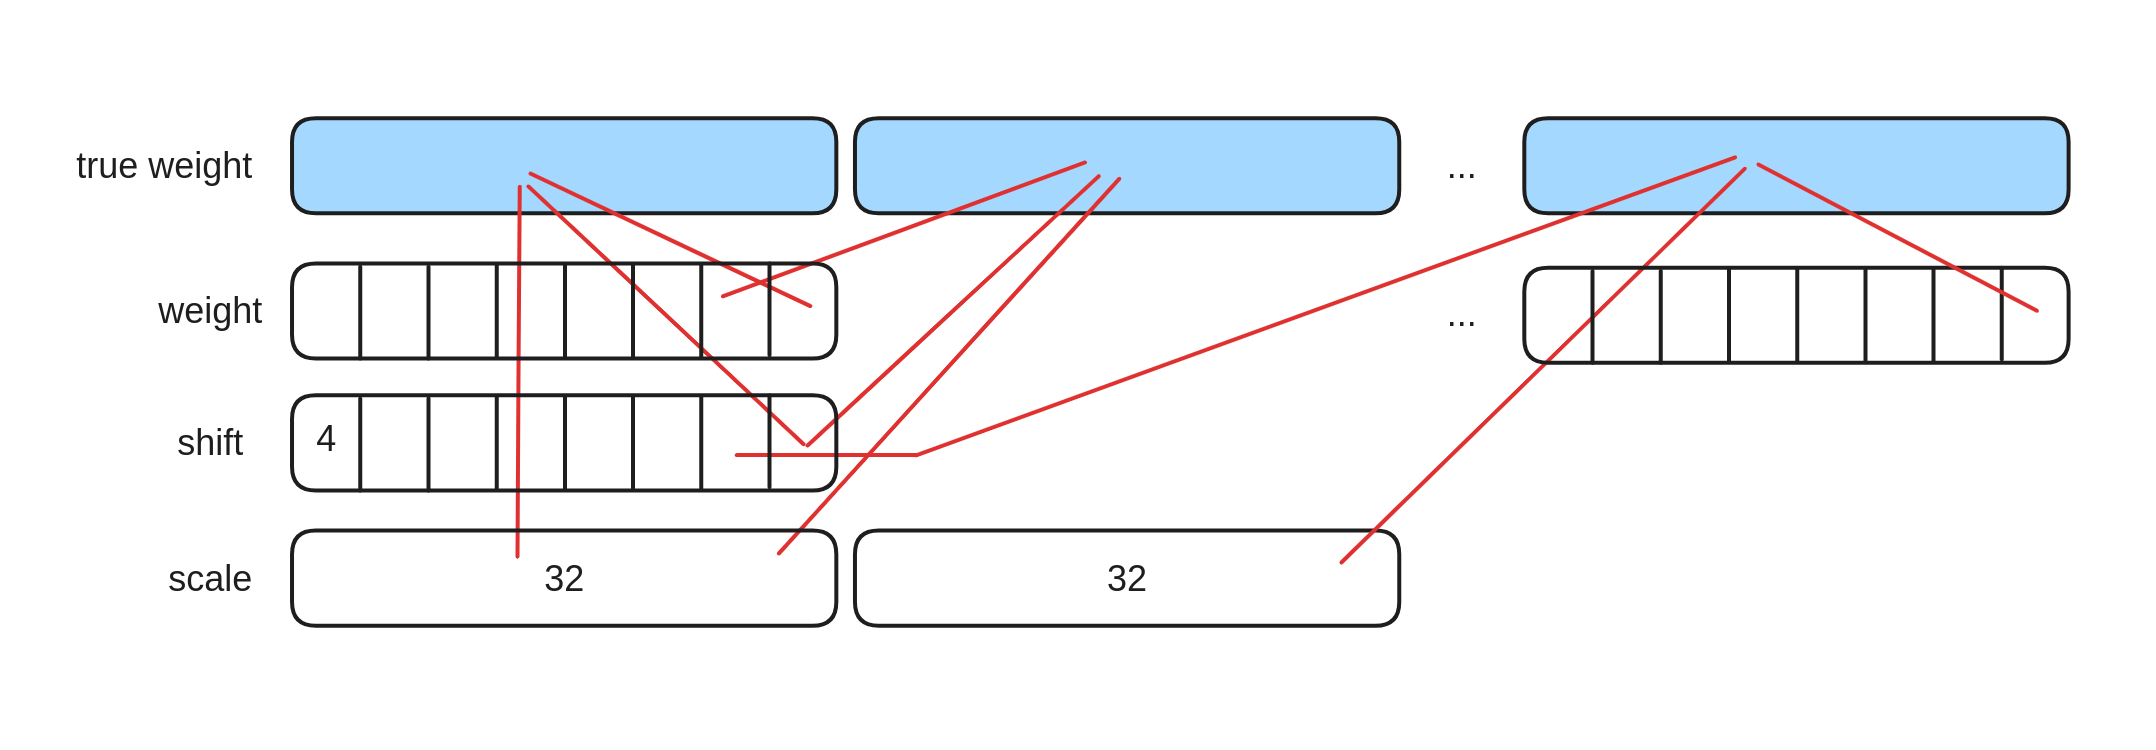

In [ ]:

FPINT = 32 // 4
GROUP = 8

def quant_dot_spec(scale : Float32[Tensor, "32 8"],
                   offset : Int32[Tensor, "32"],
                   weight: Int32[Tensor, "32 8"],
                   activation: Float32[Tensor, "64 32"]) -> Float32[Tensor, "32 32"]:
    offset = offset.view(32, 1)
    def extract(x):
        over = torch.arange(8) * 4
        mask = 2**4 - 1
        return (x[..., None] >> over) & mask
    scale = scale[..., None].expand(-1, 8, GROUP).contiguous().view(-1, 64)
    offset = extract(offset)[..., None].expand(-1, 1, 8, GROUP).contiguous().view(-1, 64)
    return ( scale * (extract(weight).view(-1, 64) - offset))  @ activation

@triton.jit
def quant_dot_kernel(scale_ptr, offset_ptr, weight_ptr, activation_ptr,
                     z_ptr, N0, N1, MID, B0: tl.constexpr, B1: tl.constexpr, B_MID: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)

test(quant_dot_kernel, quant_dot_spec, B={"B0": 16, "B1": 16, "B_MID": 64},
                                       nelem={"N0": 32, "N1": 32, "MID": 64})
